# **Preprocesamiento del DATA**

El DATA está constituido por un conjunto de imágenes aéreas en formato TIFF.
Tienen un tamaño de (5k * 5k) px y pesan sobre 1Mb cada una.

Cada una de las imagénes cuenta con su propio ground truth que representa con un pixel blanco si en la imagen original ese punto se corresponde con un edificio o no (pixel negro).

Fase 1: dividir las imágenes, transformarlas a un formato sin pérdida (PNG) y descartar aquellas poco significativas.

  Fase 1.1: Se recorren los directorios de imágenes aéreas y el de ground truths y cada imágen se divide en 81 de tamaño (512 * 512) px

In [3]:
import os, cv2, numpy, matplotlib.pyplot as plt

# Se monta el gdrive donde está el DATA
from google.colab import drive
drive.mount('/content/gdrive')

# Rutas del sistema de archivos de las imágenes
commonPath = "/content/gdrive/MyDrive/DATA/"

# Imágenes aéreas originales
aerialImagesInputPath = os.path.join(commonPath,"INPUT")
# Ground truths de las imágenes aéreas originales
aerialImagesGTInputPath = os.path.join(commonPath,"INPUT_GT")
# Imágenes aéreas divididas en trozos de 512*512 px, formato PNG
aerialImagesOutputPath= os.path.join(commonPath,"OUTPUT")
# Ground truths de las imágenes aéreas divididas en trozos de 512*512 px, formato PNG
aerialImagesGTOutputPath= os.path.join(commonPath,"OUTPUT_GT")
# Modelos una vez entrenados
modelsPath = os.path.join(commonPath,"MODELS_BACKUP")

########################################################################
# Función generateTiles()
#
# Recorre un directorio, divide las imágenes TIFF que contiene
# en trozos de 512*512 y las pega en otro en formato PNG
#
# Parámetros: directorio de entrada y directorio de salida
#
# Salida: no devuelve nada. Rellena el directorio de salida
#########################################################################

def generateTiles(inputPath, outputPath):

  # Se lista el contenido de la ruta
  # que llega como parámetro de entrada
  files = os.listdir(inputPath)

  # Se recorre la lista de nombres de las imágenes
  for file in files:

    # Se captura el nombre de cada imagen sin su extensión      
    imageName = file.split('.')
    filename = imageName[0]

    # Se lee cada imagen TIFF
    # El segundo parámetro es el parámetro del número de canal y la profundidad de bits,
    # IMREAD_COLOR = 1
    # Para poder convertir a imagen RGB de tres canales, la profundidad de la imagen se convierte a 8 bits
    img = cv2.imread(os.path.join(inputPath,file),1)

    # Se recorta cada imágen y se graba en el directorio de salida
    # en un formato más adecuado para que puedan ser tratadas por la red neuronal: PNG (sin pérdida)
    for i in range(0, 4608, 512):
      for j in range(0, 4608, 512):

        cropImg = img[i:i+512, j:j+512]
        cv2.imwrite(os.path.join(outputPath,filename + "_" + str(i) + "_" + str(j) + ".png"), cropImg)

# Se recortan todas las imágenes originales
generateTiles(aerialImagesInputPath,aerialImagesOutputPath)

# Se recortan todos los GT
generateTiles(aerialImagesGTInputPath, aerialImagesGTOutputPath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Función isGroundTruthValid()**

In [2]:
########################################################################
# Función isGroundTruthValid()
#
# Comprueba si un ground truth tiene un nº de pixels correspondientes 
# a edificios aceptable. 
# La tasa de validación se estima entre al menos un 10% y 
# un máximo de un 90%
#
# Parámetros: ruta al ground truth
#
# Salida: true (tiene al menos un 10% de edificios y no más de un 90%) | 
#         false (tiene menos de un 10% ó mas de un 90%)
#########################################################################

def isGroundTruthValid(path):

  # Se abre el ground truth
  data = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

  # Se obtiene el tamaño de la imagen
  nPixels = data.size
  
  # Se calcula cuál es el 10% de los pixels
  tenPercent = nPixels * 0.1

  # Se calcula cuál es el 90% de los pixels
  ninetyPercent = nPixels * 0.9

  # Se recorre el array y se van contando los pixels blancos
  # cuyo valor es 255 (edificios). Los que valen 0 son los negros.

  whitePixels = 0
  isValid = False

  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      
      if (data[i][j] > 127):

        whitePixels = whitePixels + 1

        if (whitePixels > tenPercent):
          isValid = True

        if (whitePixels > ninetyPercent):
          return False
    
  return isValid

Fase 1.2: Se recorren los ground truths de salida, y aquellos que no tengan al menos un 10% y un máximo de 90% de pixels correspondientes a edificios se borran (tanto el GT como su imagen de referencia)

In [4]:
# Se listan los GT de salida
files = os.listdir(aerialImagesGTOutputPath)

# Se recorren los GT y si son no válidos se borran  
for file in files:     
  if not (isGroundTruthValid(os.path.join(aerialImagesGTOutputPath,file))):
    print("Se borra " + file)
    os.remove(os.path.join(aerialImagesOutputPath,file)) 
    os.remove(os.path.join(aerialImagesGTOutputPath,file)) 


Se borra vienna5_0_2048.png
Se borra vienna5_0_2560.png
Se borra vienna5_0_3072.png
Se borra vienna5_0_3584.png
Se borra vienna5_0_4096.png
Se borra vienna5_512_2048.png
Se borra vienna5_512_2560.png
Se borra vienna5_512_3072.png
Se borra vienna5_512_3584.png
Se borra vienna5_512_4096.png
Se borra vienna5_1024_2560.png
Se borra vienna5_1024_3072.png
Se borra vienna5_1024_3584.png
Se borra vienna5_1024_4096.png
Se borra vienna5_1536_3072.png
Se borra vienna5_1536_3584.png
Se borra vienna5_1536_4096.png
Se borra vienna5_2048_2048.png
Se borra vienna5_2048_3584.png
Se borra vienna5_2048_4096.png
Se borra vienna5_2560_1536.png
Se borra vienna5_2560_2048.png
Se borra vienna5_2560_4096.png
Se borra vienna5_3072_1536.png
Se borra vienna5_3072_2048.png
Se borra vienna5_3584_1536.png
Se borra vienna5_3584_2048.png
Se borra vienna5_4096_1536.png
Se borra vienna5_4096_2048.png
Se borra vienna5_4096_3072.png


**Recuento de imágenes óptimas**: una vez preprocesado el DATA, se consulta con cuántas imágenes se alimentarán los modelos

In [ ]:
path, dirs, files = next(os.walk(aerialImagesGTOutputPath))
file_count = len(files)
print(file_count)

# El resultado son 530 fotos, si se toman como input Austin1..Austin10.

# El resultado son 1974, si se toman como input todas las de Austin

1974


# **Construcción de los Generadores de Datos**

Funciones auxiliares:

In [ ]:
########################################################################
# Función addBChannel()
#
# Añade el canal B a la imagen para que pueda ser displayada
#
# Parámetros: imagen con shape (512,512,2)
#
# Salida: imagen displayable con shape (512, 512, 3)
#########################################################################

def addBChannel(x):
  
  y = numpy.zeros(shape=(512,512,3))
  y[:,:,:-1] = x

  return y

########################################################################
# Función correctGt(()
#
# Corrige los ground truth del DATASET a un formato categorizable
#
# Parámetros: ground truth con 3 canales; 
#             valor 255 para los edificios y 0 para el fondo
#
# Salida: imagen no displayable con shape (512, 512);
#         valor 1 para los edificios y 0 para el fondo
#########################################################################

def correctGt(input):

  input[input<128]=0
  input[input>=128]=1

  output = numpy.zeros(shape=(512,512))
  output[:,:] = input[:,:,0]
  
  return numpy.array(output)

########################################################################
# Función reverseGt()
#
# Corrige la categorización de un ground truth
# Los pixels 1, los convierte en 0 y viceversa
#
# Parámetros: ground truth no displayable con shape (512,512)
#
# Salida: ground truth no displayable con shape (512,512)
#         con las clases invertidas
#########################################################################

def reverseGt(input):

  input[input>=1]=-1
  input[input>=0]=1
  input[input<=-1]=0

  output = numpy.zeros(shape=(512,512))
  output[:,:] = input[:,:]
  
  return numpy.array(output)

########################################################################
# Función convertIntoImg()
#
# Convierte una imagen no displayable de shape (512,512)
# en una imagen displayable de 3 canales con shape (512, 512, 3)
#
# Parámetros: imagen shape (512,512)
#
# Salida: imagen displayable con shape (512, 512, 3)
#########################################################################

def convertIntoImg(x):
  
  y = numpy.zeros(shape=(512,512,3))
  y[:,:,0] = x

  return y

########################################################################
# Función getRchannel()
#
# Recupera el canal R de una imagen
#
# Parámetros: imagen shape (512,512,3)
#
# Salida: canal R de la imagen de entrada con shape (512, 512)
#########################################################################

def getRchannel(theImage):

    theData=theImage[:,:,0].copy()

    return theData

########################################################################
# Función getDiffBetweenGt()
#
# Obtiene la diferencia entre dos ground truths (gt) (en valor absoluto)
#
# Parámetros: gt1 con shape (512,512) y gt2 con shape (512,512)
#
# Salida: gt de la diferencia en valor absoluto con shape (512, 512)
#########################################################################

def getDiffBetweenGt(gt1, gt2):

  subtractGt = numpy.subtract(gt1, gt2)
  absSubtractGt = numpy.absolute(subtractGt)

  return absSubtractGt


**Definición del DATAGENERATOR**: con aumentación de datos. De 2 tipos, FLIPS y ROTACIONES

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from skimage.util import img_as_float

class DataGenerator(Sequence):
    ###############################################################################################################
    # __init__ (constructor)
    # 
    # Parámetros:
    #
    # - doRandomize  : Si es True, los ficheros se desordenan después de cada training epoch. 
    #                  Debe llegar a True para el conjunto de training 
    #                  Debe llegar a False para los conjuntos de validation y test (no vale para nada barajar)
    # - applyFlips   : Si es True, hacemos flips de las imágenes (y de los ground truth)
    # - applyRotation: Si es True, se rotan las imágenes (y los ground truth)
    # - fileNames    : Lista de los nombres de las imágenes
    # - imgPath      : Ruta a las imágenes
    # - gtPath       : Ruta a los ground truth 
    # - batchSize    : Nº de imágenes aéreas y ground truth en cada lote
    ################################################################################################################
    def __init__(self,fileNames,doRandomize=False,applyFlips=False,applyRotation=False,imgPath=aerialImagesOutputPath,gtPath=aerialImagesGTOutputPath,batchSize=10):
        
        self.imgPath=imgPath
        self.gtPath=gtPath
        self.fileNames=fileNames
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.applyFlips=applyFlips
        self.applyRotation=applyRotation
        self.numImages=len(self.fileNames)
        self.on_epoch_end()

    # Se baraja en cada epoch si se solicita
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)
    
    # Carga la imagen y su correspondiente ground truth
    def _load_image_pair_(self,imageIndex):

        samplePic = imread(fname= os.path.join(self.imgPath,self.fileNames[imageIndex]))  
        t_image = img_as_float(numpy.array(samplePic))
        theImage = numpy.array(t_image)

        gtPic = imread(fname= os.path.join(self.gtPath,self.fileNames[imageIndex]))
        # Se categoriza PROVISIONALMENTE a 3 clases
        # para poder hacer los flips y los rotates fácilmente
        g_Image = to_categorical(correctGt(gtPic),3)
        gtImage = numpy.array(g_Image)
        # Devuelve la imagen en el intervalo [0,1] (theImage)
        # y su ground truth (gtImage)
        return theImage, gtImage
            
    # Devuelve el nº de lotes
    def __len__(self):
        return int(numpy.ceil(float(self.numImages)/float(self.batchSize)))

    # Devuelve el item theIndex-ésimo
    def __getitem__ (self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)

        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_pair_(i)

            ########################
            # AUMENTACIÓN DE DATOS
            ########################

            #########################
            # FLIP
            # 
            # Para hacer un tipo de flip aleatorio del lote
            # Se genera un entero aleatorio entre -1 y 1:
            # Posibles valores: -1, 0 y 1. 
            #
            # flipMode =  0: flip vertical
            # flipMode =  1: flip horizontal
            # flipMode = -1: flip vertical y horizontal
            #########################

            if self.applyFlips:

                flipMode = random.randint(-1,1)

                flipImg = cv2.flip(curImage, flipMode)
                X.append(flipImg)
                flipGT = cv2.flip(curGT, flipMode)
                # Se borra el canal B, para tener 2 clases a la salida, fondo y edificio
                flipGTwoB =flipGT[:,:,:2]
                
                y.append(flipGTwoB)
                 
            #########################
            # ROTACIÓN
            # 
            # Para crear una rotación aleatoria del lote
            # Se genera un entero aleatorio entre -1 y 1:
            # Posibles valores: -1, 0 y 1. 
            #
            # rotationMode =  0: rota 180 grados
            # rotationMode =  1: rota  90 grados
            # rotationMode = -1: rota 270 grados
            #########################

            elif self.applyRotation:

                indice = random.randint(-1,1)

                if indice==0:
                    rotationMode = cv2.ROTATE_180
                elif indice==1:
                    rotationMode = cv2.ROTATE_90_CLOCKWISE
                else:
                    rotationMode = cv2.ROTATE_90_COUNTERCLOCKWISE

                rotationImg = cv2.rotate(curImage, rotationMode)
                X.append(rotationImg)
                rotationGT = cv2.rotate(curGT, rotationMode)
                # Se borra el canal B, para tener 2 clases a la salida, fondo y edificio
                rotationGTwoB=rotationGT[:,:,:2]
                y.append(rotationGTwoB)

            else: 
                X.append(curImage)
                # Se borra el canal B, para tener 2 clases a la salida, fondo y edificio
                curGTwoChB=curGT[:,:,:2]
                y.append(curGTwoChB)
            
        return numpy.array(X),numpy.array(y)

**Función splitData**

In [ ]:
import random

########################################################################
# Función splitData()
#
# Divide el DATA en los 3 conjuntos de datos
# (70% trainSet | 20% testSet | 10% valSet) 
#
# Parámetros: ruta de las imágenes en formato PNG (sin pérdida)
#
# Salida: conjunto de datos de entrenamiento, test y validación
#########################################################################

def splitData(path):


  # Se declara un array donde guardar
  # los nombres de las imágenes
  imagenes = []

  # Se lista el contenido de la ruta
  # que llega como parámetro
  files = os.listdir(path)

  # Se recorre la lista de nombres de las imágenes, 
  # y se guarda en el array inicial
  for file in files:      
    imagenes.append(file)

  # Se desordena el array, 
  # para lograr que el contenido sea aleatorio
  random.shuffle(imagenes)

  # Se calcula el corte donde estarán el 70% de las imágenes.
  # Desde el ppio del array hasta este índice se encontrarán
  setenta = int(len(imagenes) * 0.7)
  # Se calcula cuántas serán el 20% de las imágenes.
  # Los cortes serán, desde donde acabe el 70% (trainSet) y
  # para calcular el límite superior se sumará esta cantidad
  veinte = int(len(imagenes) * 0.2)

  # En el trainSet estará el 70% del array
  trainSet = imagenes[:setenta]
  # En el testSet el 20 %
  testSet = imagenes[setenta:setenta+veinte]
  # En el valSet el contenido restante, esto es: el 10%
  valSet = imagenes[setenta+veinte:]

  # Se devuelven las 3 listas pedidas
  return trainSet, testSet, valSet

**Obtención de los generadores de datos de cada conjunto**

In [ ]:
# Se dividen los PNG
trainSet, testSet, valSet = splitData(aerialImagesOutputPath)

# Se crea el trainGenerator
trainGenerator = DataGenerator(trainSet, True, False, False)
# Prueba con aumentación de datos "FLIPS"
# trainGenerator = DataGenerator(trainSet, True, True, False)
# Prueba con aumentación de datos "ROTACIÓN"
# trainGenerator = DataGenerator(trainSet, True, False, True)

#Se crea el testGenerator
testGenerator=DataGenerator(testSet, True, False, False)
#Se crea el valGenerator
valGenerator=DataGenerator(valSet, True, False, False)

# **ESTUDIO DE MODELOS SECUENCIALES**

Para ilustrarlo se usa la arquitectura ENCODER-DECODER



Primera prueba (9 capas): 

Filtros del Conv2D: 

Encoder: Primera capa (4), segunda (8)
Decoder: Primera capa (8), segunda (4)

El modelo tiene pocos parámetros (1.358) y como se aprecia en los resultados de 2 ejecuciones, no converge.

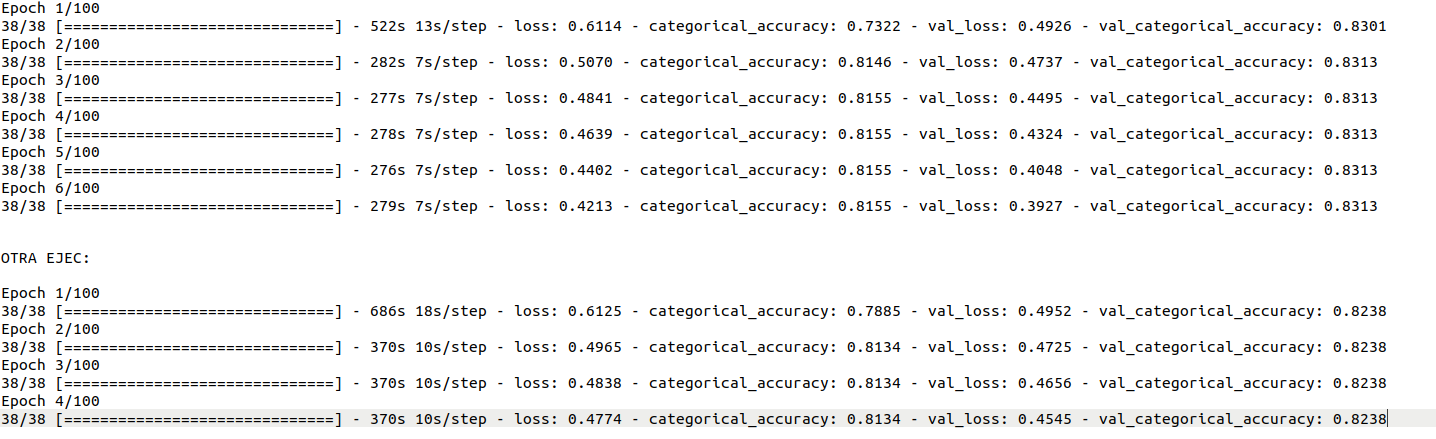

Segunda prueba (mismo nº de capas, 9):

Filtros del Conv2D:

Encoder: Primera capa (64), segunda (128) 
Decoder: Primera capa (128), segunda (64)

Al aumentar los filtros, hay muchos más parámetros (298.000), la ejecución llega hasta la epoch 18 antes de que COBA se pare. Se obtiene un accuray aceptable (89%)


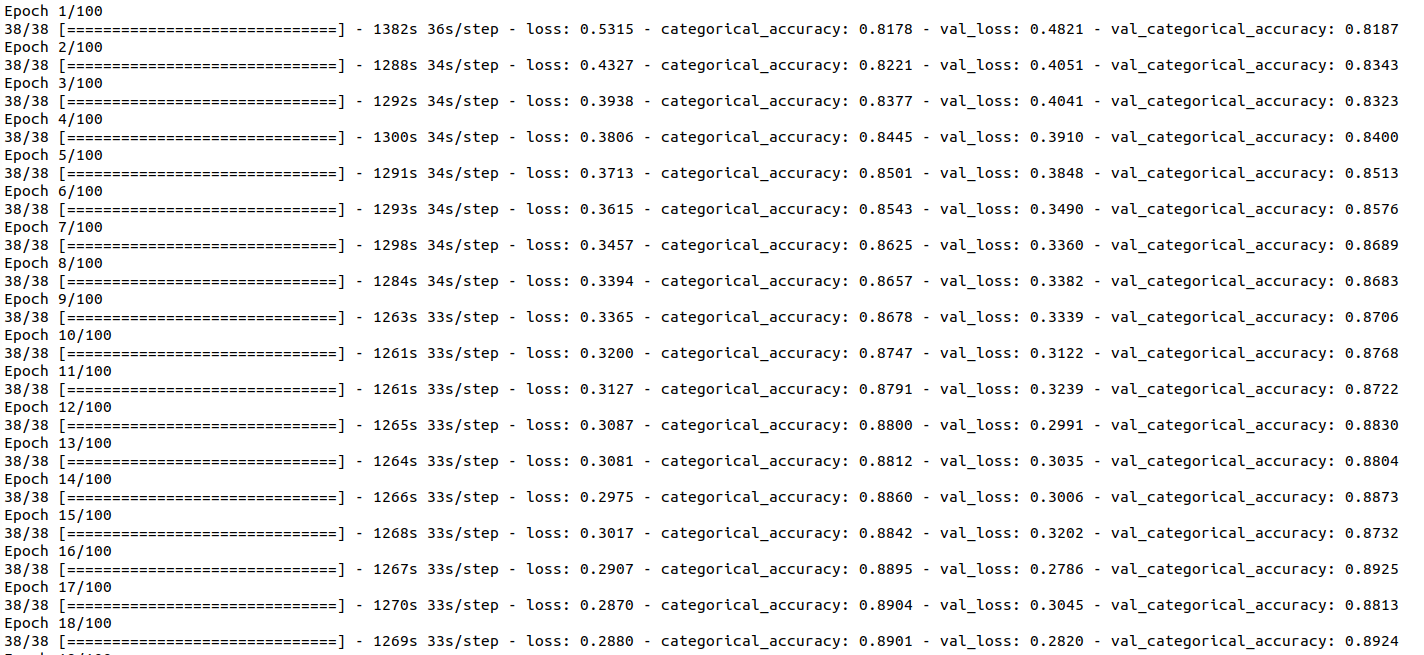

Tercera prueba: más capas que las 2 pruebas anteriores (17), con un número de filtros intermedio, para obtener unos 20.000 parámetros.

Este es el test que se da como bueno al obtener un accuracy del 90% - 91%


In [ ]:
# Modelo secuencial tomado como bueno

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D


def create_and_compile_model():
    theModel=models.Sequential([
       
        # FASE ENCODER
        Conv2D(4, (3, 3), activation='relu', padding='same',input_shape=(512,512,3)),
        MaxPooling2D((2, 2), padding='same'),
       
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),

        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),

        # FASE DECODER    
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
      
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
       
        Conv2D(4, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),

        Conv2D(2, (3, 3), activation='softmax', padding='same')
       
 
    ])
    

    # Se compila el modelo
    optimiz=optimizers.Adam()
    theModel.compile(optimizer=optimiz, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return theModel

# Se crea y compila el modelo
theModel=create_and_compile_model()

# Se pinta el resumen
theModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 512, 512, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 256, 4)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 8)       296       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)      

Se entrena el modelo una precisión en la categorización del 91%

In [ ]:
epochs = 50
trainHistory = theModel.fit(trainGenerator, epochs=epochs, validation_data=valGenerator)



Epoch 1/50
38/38 [==============================] - 478s 12s/step - loss: 0.5518 - categorical_accuracy: 0.7977 - val_loss: 0.5081 - val_categorical_accuracy: 0.8131
Epoch 2/50
38/38 [==============================] - 287s 8s/step - loss: 0.4971 - categorical_accuracy: 0.8148 - val_loss: 0.4856 - val_categorical_accuracy: 0.8145
Epoch 3/50
38/38 [==============================] - 287s 8s/step - loss: 0.4515 - categorical_accuracy: 0.8156 - val_loss: 0.4133 - val_categorical_accuracy: 0.8145
Epoch 4/50
38/38 [==============================] - 284s 7s/step - loss: 0.4197 - categorical_accuracy: 0.8168 - val_loss: 0.3942 - val_categorical_accuracy: 0.8327
Epoch 5/50
38/38 [==============================] - 281s 7s/step - loss: 0.3897 - categorical_accuracy: 0.8358 - val_loss: 0.3794 - val_categorical_accuracy: 0.8460
Epoch 6/50
38/38 [==============================] - 284s 7s/step - loss: 0.3795 - categorical_accuracy: 0.8435 - val_loss: 0.3690 - val_categorical_accuracy: 0.8473
Epoch 7/5

In [ ]:
# Funciones para guardar y cargar modelos entrenados

import pickle

########################################################################
# Función save_trained_model()
#
# Persiste a fichero el modelo entrenado 
#
# Parámetros: nombre del fichero a guardar
#             modelo entrenado
#             historia del entrenamiento (respuesta del fit)
#
# Salida: nada. El model entrenado queda grabado en el fichero
#########################################################################

def save_trained_model(fileName, theModel, trainHistory):

  # Se guarda el trainHistory
  with open(os.path.join(modelsPath,fileName) + '.pkl', 'wb') as historyFile:
        pickle.dump(trainHistory.history, historyFile)

  # Se salva el modelo
  theModel.save(os.path.join(modelsPath,fileName) + '.hd5')

########################################################################
# Función load_trained_model()
#
# Recupera de fichero el modelo y la historia del entrenamiento
#
# Parámetros: nombre del fichero
#             
# Salida: modelo y la historia del entrenamiento
#########################################################################

def load_trained_model(fileName):

  # Se carga el modelo
  new_model = models.load_model(os.path.join(modelsPath,fileName) + '.hd5')

  # Se carga el trainHistory
  historyStream = open(os.path.join(modelsPath,fileName) + '.pkl','rb')
  historyFile = pickle.load(historyStream)
  historyStream.close()

  return new_model, historyFile

# Llamada a las funciones anteriores

#save_trained_model('ficherito6capas',theModel,trainHistory)
[theModel, trainHistory] = load_trained_model('ficherito6capas')

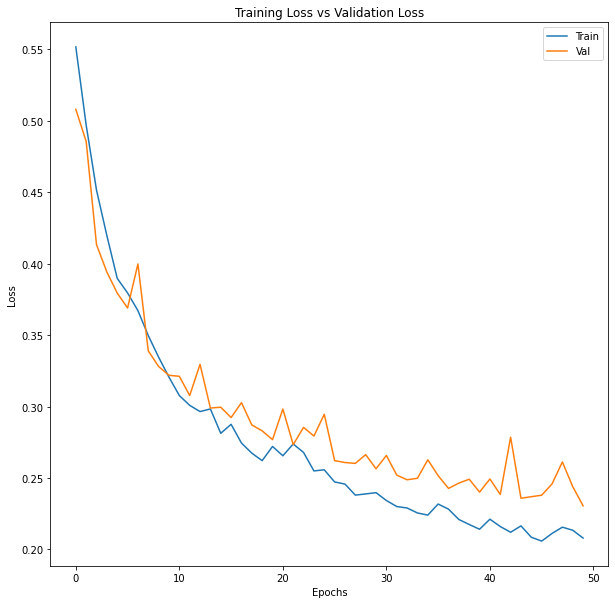

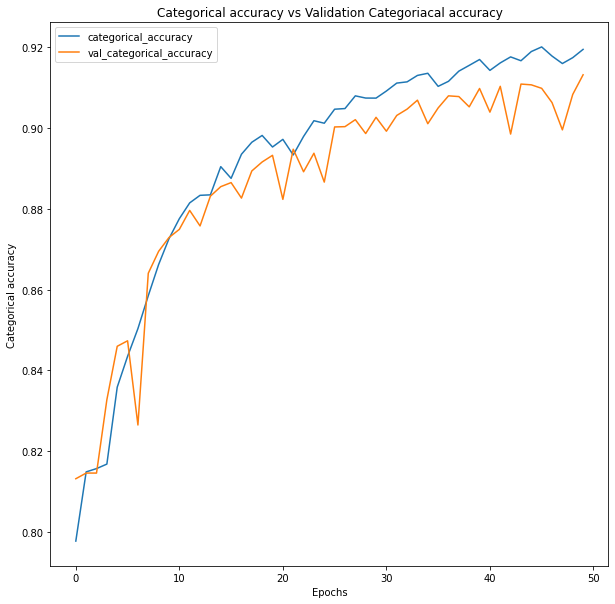

In [ ]:
# Se dibujan las gráficas de precisión y pérdida.
# Se aprecia el fenómeno del OVERFITTING

# PÉRDIDA
fig, axs = plt.subplots(figsize=(10,10))

axs.plot(trainHistory['loss'])
axs.plot(trainHistory['val_loss'])
axs.title.set_text('Training Loss vs Validation Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend(['Train','Val'])

# PRECISIÓN
fig, axs = plt.subplots(figsize=(10,10))

axs.plot(trainHistory['categorical_accuracy'])
axs.plot(trainHistory['val_categorical_accuracy'])
axs.title.set_text('Categorical accuracy vs Validation Categoriacal accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Categorical accuracy')
axs.legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
# Se evalúa el modelo con el conjunto de TEST y 
# y se aprecia que se obtienen resultados parecidos al entrenamiento.
# El entrenamiento ha sido satisfactorio

results = theModel.evaluate(testGenerator, verbose=1)

11/11 [==============================] - 167s 13s/step - loss: 0.2180 - categorical_accuracy: 0.9165


**Predicciones y medidas del modelo secuencial**

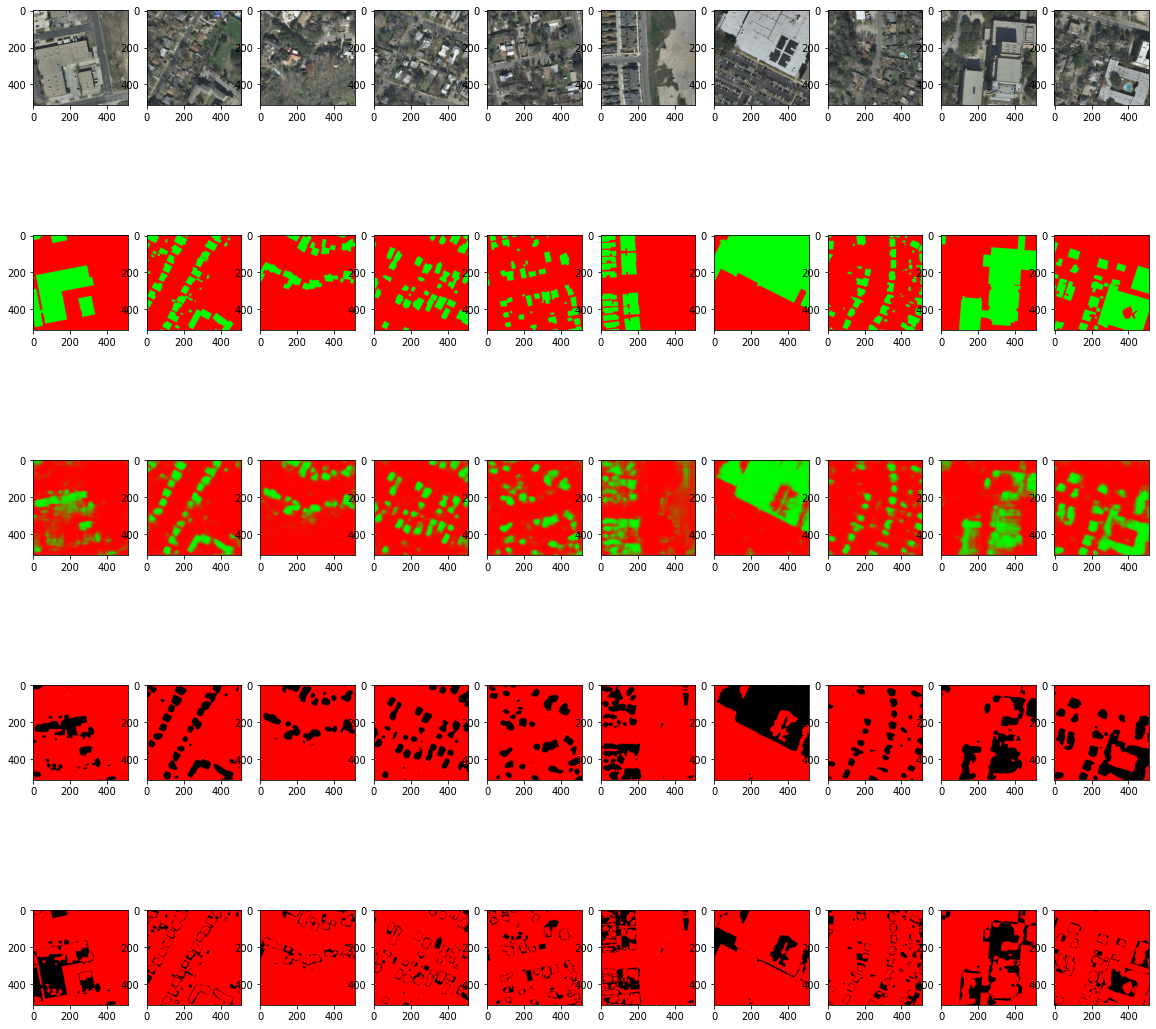

In [ ]:
###############################
# PREDICCIONES
###############################

# Se selecciona un lote, el 1 por ejemplo
[X_predict,y_predict]=testGenerator.__getitem__(1)

# Se hace una predicción de sus ground truths
# con el modelo secuencial entrenado y evaluado
prediction = theModel.predict(X_predict)

# Se dibujan 5 filas de imágenes del lote 1

# La primera con las imágenes aéreas de referencia
# La segunda con los ground truth
# La tercera con las predicciones efectuadas con probabilidades
# La cuarta con las predicciones aproximadas a sus clases con argmax
# La quinta con las diferencias entre las predicciones aproximadas a sus clases y los ground truth (en valor absoluto)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,len(X_predict),figsize=(20, 20))

for i in range(len(y_predict)):
    ax1[i].imshow(X_predict[i])
    # Se añade el canal B para poder ver el GT
    z = addBChannel(y_predict[i])
    ax2[i].imshow(z)
    # Se añade el canal B para poder ver la predicción del GT
    t = addBChannel(prediction[i])
    ax3[i].imshow(t)
    # Los ground truth predichos se aproximan a su clase
    # con la función argmax
    # Las clases que devuelve argmax, (1 y 0), son las contrarias
    # que las de devuelve predict, así que se invierten
    y = convertIntoImg(reverseGt(prediction[i].argmax(axis=-1)))
    ax4[i].imshow(y)
    # Se resta el gt con la predicción redondeada a su clase y se coge el valor absoluto de la diferencia de cada pixel
    # Así en la imagen refleja cúanto le falta a la predicción aproximada para ser el gt exacto
    d = convertIntoImg(getDiffBetweenGt(prediction[i].argmax(axis=-1), getRchannel(y_predict[i])))
    ax5[i].imshow(d)

Se observan unas predicciones bastante buenas en general, destacando la segunda por ejemplo!

In [ ]:
#####################################################
#   Funciones auxiliares para calcular las MEDIDAS
#####################################################

########################################################################
# Función load_data()
#
# Carga las predicciones y gt que queremos medir
#
# Parámetros: número de imágenes
#             
# Salida: predicciones y gts
#########################################################################

def load_data(numImages):
    allPredictions=numpy.zeros((512,512,numImages))
    allGT=numpy.zeros((512,512,numImages))

    for i in range(numImages):
        allPredictions[:,:,i]=reverseGt(prediction[i].argmax(axis=-1))
        allGT[:,:,i]=getRchannel(y_predict[i])
    
    return allPredictions,allGT

########################################################################
# Función plot_all()
#
# Pinta las predicciones y gts.
# En la primera fila los gt y en la segunda las predicciones
#
# Parámetros: predicciones y gts
#             
# Salida: nada. Se pinta por pantalla
#########################################################################

def plot_all(allPredictions,allGT):
    numImages=allPredictions.shape[2]
    plt.figure()
    for i in range(numImages):
        plt.subplot(2,numImages,i+1)
        plt.imshow(allGT[:,:,i])
        plt.subplot(2,numImages,i+1+numImages)
        plt.imshow(allPredictions[:,:,i])
    plt.show()

########################################################################
# Función get_cmatrix()
#
# Obtiene los falsos y verdaderos positivos y negativos
# entre un ground truth y su predicción (redondeada)
#
# Parámetros: una predicción redondeada y su gt
#             
# Salida: falsos y verdaderos positivos y negativos
#########################################################################

def get_cmatrix(thePrediction,theGT):
    tp=numpy.sum(numpy.logical_and(thePrediction==1,theGT==1))
    fp=numpy.sum(numpy.logical_and(thePrediction==1,theGT==0))
    tn=numpy.sum(numpy.logical_and(thePrediction==0,theGT==0))
    fn=numpy.sum(numpy.logical_and(thePrediction==0,theGT==1))
    
    return tp,fp,tn,fn

########################################################################
# Función get_global_cmatrix()
#
# Obtiene el total de falsos/verdaderos positivos/negativos del lote
#
# Parámetros: predicciones y gts
#             
# Salida: Suma de falsos y verdaderos positivos y negativos
#########################################################################

def get_global_cmatrix(allPredictions,allGT):
    tp=fp=tn=fn=0
    numImages=allPredictions.shape[2]
    for i in range(numImages):
        curTP,curFP,curTN,curFN=get_cmatrix(allPredictions[:,:,i],allGT[:,:,i])
        tp+=curTP
        fp+=curFP
        tn+=curTN
        fn+=curFN
    return tp,fp,tn,fn

########################################################################
# Función get_stats()
#
# Calcula las métricas de la matriz de confusión
#
# Parámetros: falsos y verdaderos positivos y negativos
#             
# Salida: Accuracy, precision, recall y F1 score
#########################################################################

def get_stats(tp,fp,tn,fn):
    theAccuracy=(tp+tn)/(tp+fp+tn+fn)
    thePrecision=tp/(tp+fp)
    theRecall=tp/(tp+fn)
    theF1Score=2*tp/(2*tp+fp+fn)
    return theAccuracy,thePrecision,theRecall,theF1Score

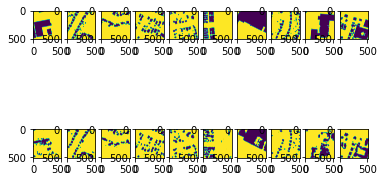

Accuracy: 0.883 Precision: 0.885 Recall: 0.969 F1 score: 0.925


In [ ]:
# Cálculo de las medidas

# Carga las predicciones y sus gts
allPredictions,allGT=load_data(10)

# Los pinta
plot_all(allPredictions,allGT)

# Obtiene el nº total de falsos y verdaderos positivos y negativos
tp,fp,tn,fn=get_global_cmatrix(allPredictions,allGT)

# Calcula las métricas
a,p,r,f1=get_stats(tp,fp,tn,fn)

# Displaya las métricas
print('Accuracy: %.3f Precision: %.3f Recall: %.3f F1 score: %.3f'%(a,p,r,f1))

Se obtienen medidas congruentes con las del entrenamiento y evaluación del modelo secuencial

# **ESTUDIO DE MODELOS PREENTRENADOS**


In [ ]:
# Se instalan los paquetes necesarios
!pip install segmentation-models
!pip install keras-applications
!pip install image-classifiers
!pip install efficientnet

%env SM_FRAMEWORK=tf.keras

     |████████████████████████████████| 50 kB 5.0 MB/s 
env: SM_FRAMEWORK=tf.keras


Se intentar utilizar distintos modelos preentrenados

VGG-16

Inceptionv3

EfficientNet


pero se descartan porque necesitan una input shape fija para poder entrenarlos 
sin redimensionado.

Fuente: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/



En primer lugar se estudia el modelo Resnet34 (estudiado en la práctica de IAA)

In [ ]:
from segmentation_models import Unet

modelUnet = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, input_shape=(512,512,3), classes=2) 
modelUnet.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

modelUnet.summary()

Segmentation Models: using `tf.keras` framework.
85532672/85521592 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                             

Con congelación y pocas fotos, se obtienen resultados peores que con el secuencial

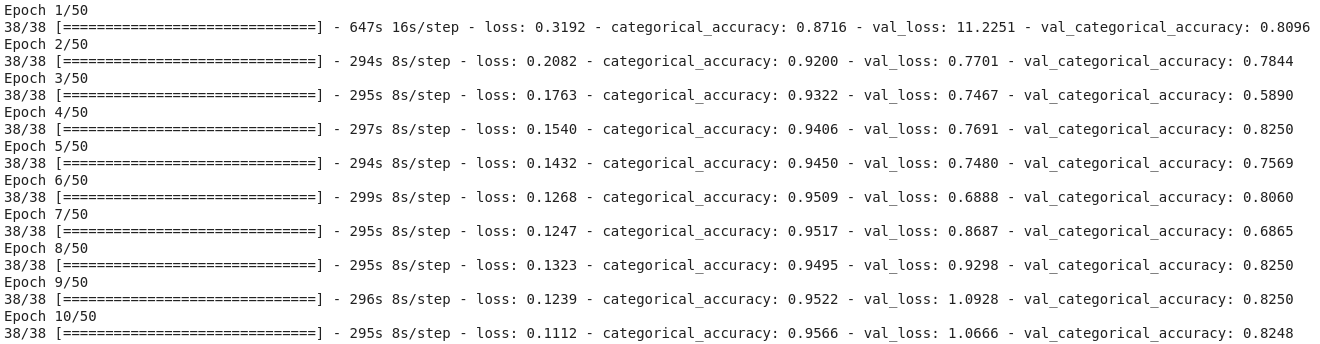

In [ ]:
modelUnet.fit(
    trainGenerator,
    batch_size=10,
    epochs=20,
    validation_data=valGenerator
)

Epoch 1/20
139/139 [==============================] - 7585s 54s/step - loss: 0.2839 - categorical_accuracy: 0.8829 - val_loss: 1.3614 - val_categorical_accuracy: 0.7830
Epoch 2/20
139/139 [==============================] - 7502s 54s/step - loss: 0.1845 - categorical_accuracy: 0.9283 - val_loss: 0.6438 - val_categorical_accuracy: 0.7822
Epoch 3/20
139/139 [==============================] - 7898s 57s/step - loss: 0.1650 - categorical_accuracy: 0.9360 - val_loss: 0.7975 - val_categorical_accuracy: 0.7832
Epoch 4/20
  3/139 [..............................] - ETA: 2:01:23 - loss: 0.1589 - categorical_accuracy: 0.9380

Sin congelación y pocas fotos, resultados parecidos:

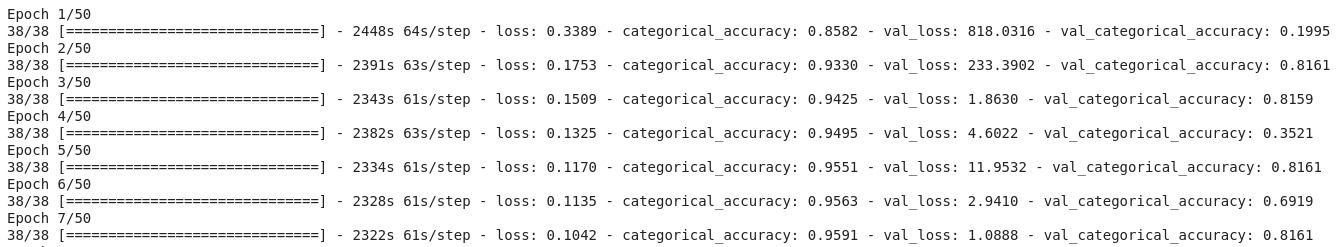

Se oberva que los resultados del modelo preentrenado (resnet34) son peores que los del modelo secuencial.

Se decide alimentar al modelo con más imágenes (uns 2.000)

Con congelación y 2.000 imágenes: resultado del entrenamiento antes de que el entorno de ejecución de COLAB se parase (unas 2 horas por epoch)

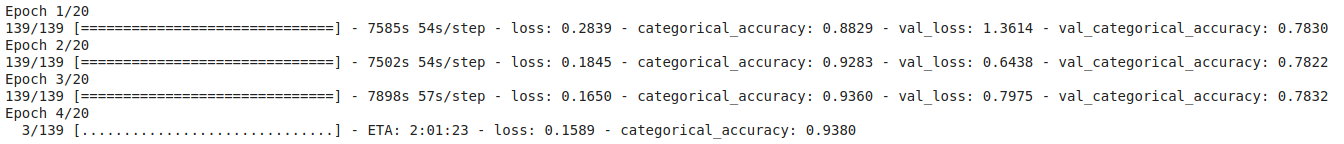

Estudio del modelo preentrenado Resnet50

In [ ]:
modelUnet = Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=True, input_shape=(512,512,3), classes=2) 
modelUnet.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

modelUnet.summary()

94601216/94592056 [==============================] - 19s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                          

Prueba 1: Colab paró en la epoch 15

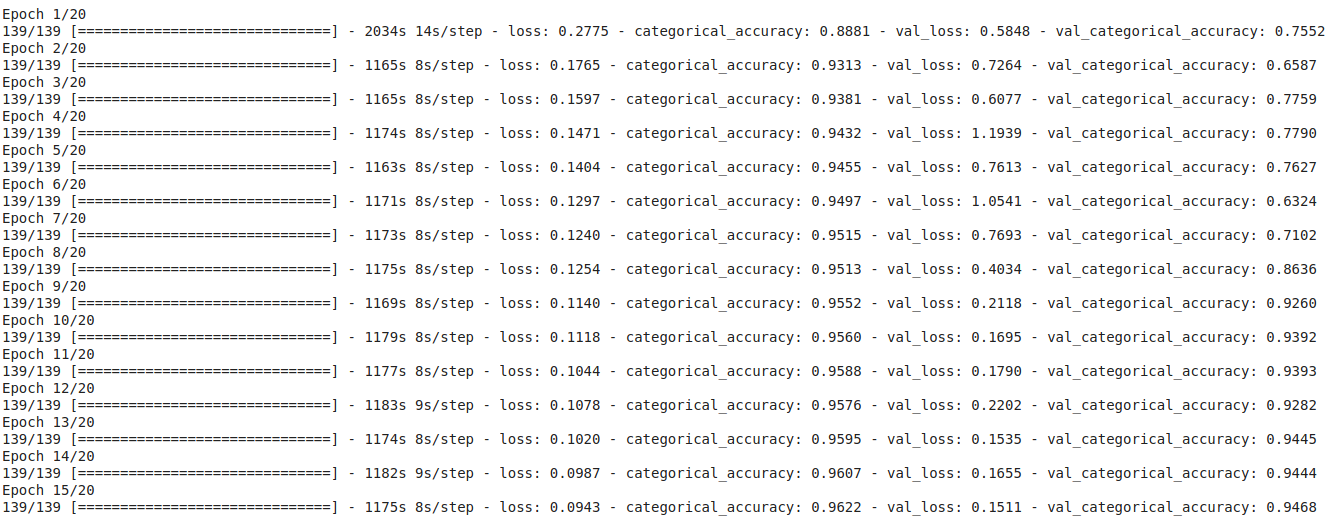

Prueba 2: Colab paró en la epoch 18 (a solo 2 de acabar)

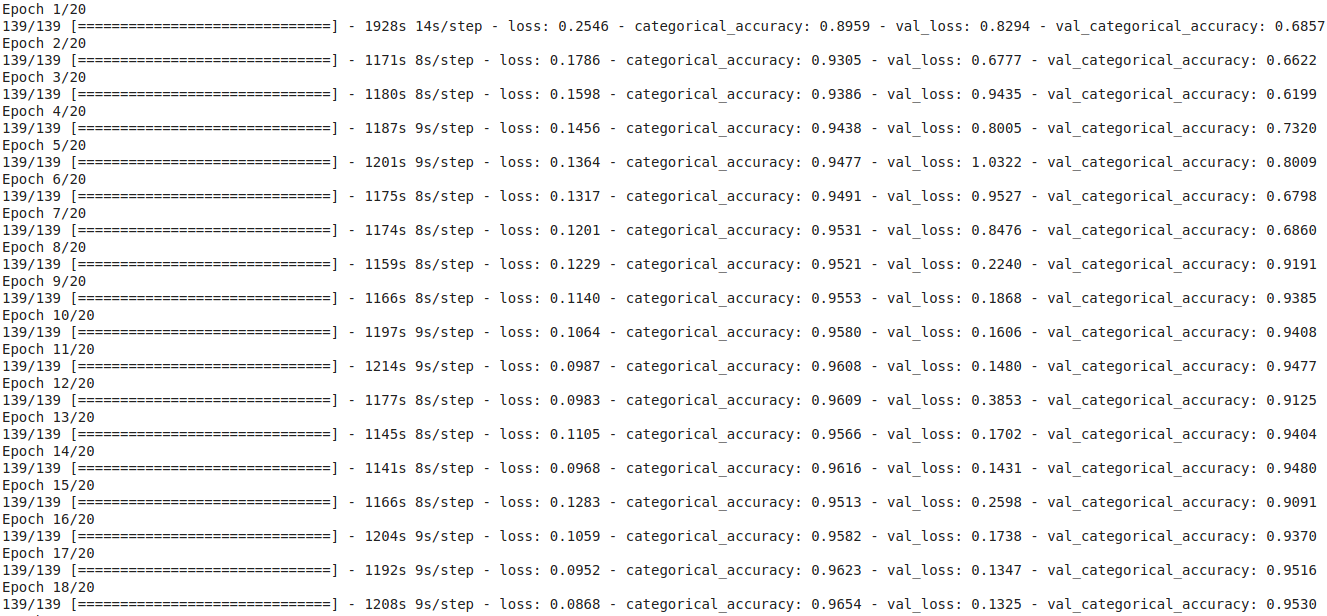

In [ ]:
# Se determina que el overfitting empieza sobre el epoch 14 y se consigue completar el entrenamiento.
# Resultados buenos, la precisión de la categorización está entorno a 94-95%

trainHistory = modelUnet.fit(
    trainGenerator,
    batch_size=10,
    epochs=14,
    validation_data=valGenerator
)

Epoch 1/14
139/139 [==============================] - 3769s 27s/step - loss: 0.2796 - categorical_accuracy: 0.8848 - val_loss: 7.9977 - val_categorical_accuracy: 0.2365
Epoch 2/14
139/139 [==============================] - 1194s 9s/step - loss: 0.1819 - categorical_accuracy: 0.9290 - val_loss: 0.6986 - val_categorical_accuracy: 0.6093
Epoch 3/14
139/139 [==============================] - 1195s 9s/step - loss: 0.1593 - categorical_accuracy: 0.9384 - val_loss: 1.3692 - val_categorical_accuracy: 0.2216
Epoch 4/14
139/139 [==============================] - 1203s 9s/step - loss: 0.1470 - categorical_accuracy: 0.9430 - val_loss: 0.6575 - val_categorical_accuracy: 0.7484
Epoch 5/14
139/139 [==============================] - 1195s 9s/step - loss: 0.1360 - categorical_accuracy: 0.9472 - val_loss: 0.5393 - val_categorical_accuracy: 0.7996
Epoch 6/14
139/139 [==============================] - 1191s 9s/step - loss: 0.1293 - categorical_accuracy: 0.9496 - val_loss: 0.5447 - val_categorical_accuracy

In [ ]:
# Se guarda el modelo, con la función anterior

save_trained_model('resnet50',modelUnet,trainHistory)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DATA/COPIASEG/resnet50.hd5/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Se evalua con el conjunto de test y se comprueba que el entrenamiento es satisfactorio, resultados parecidos en la evaluación

results = modelUnet.evaluate(testGenerator, verbose=1)

40/40 [==============================] - 911s 23s/step - loss: 0.1694 - categorical_accuracy: 0.9409


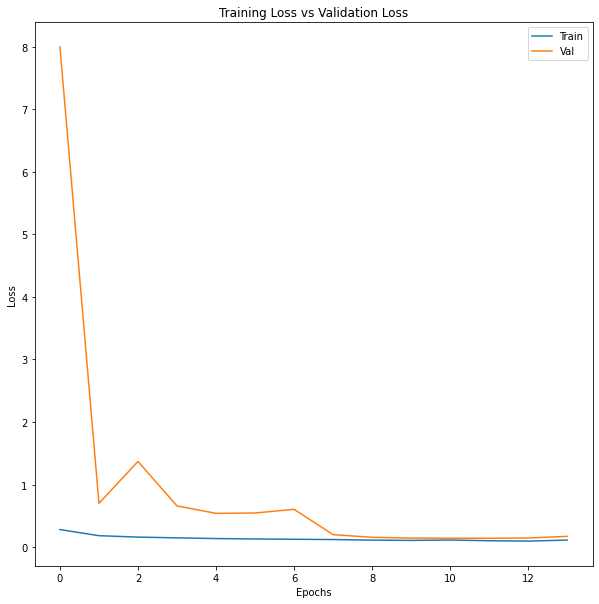

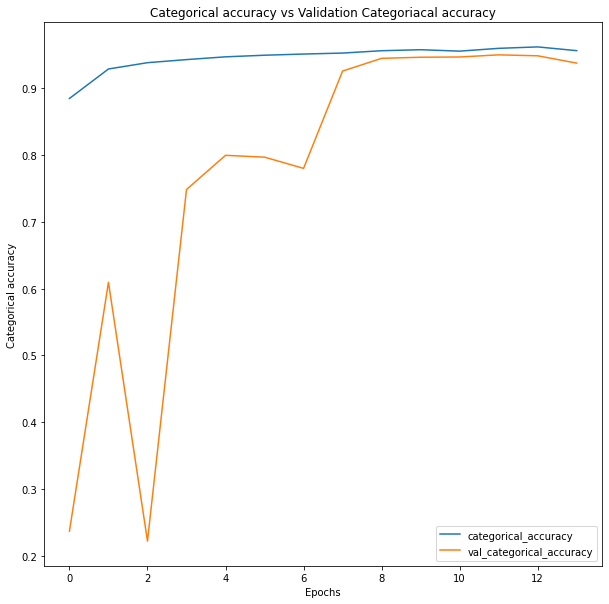

In [ ]:
# Se pintaN loss y accuracy, como se hizo hasta el overfitting no se aprecia y no sigue bajando loss...
[theModel, trainHistory] = load_trained_model('resnet50')

# PÉRDIDA
fig, axs = plt.subplots(figsize=(10,10))

axs.plot(trainHistory['loss'])
axs.plot(trainHistory['val_loss'])
axs.title.set_text('Training Loss vs Validation Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend(['Train','Val'])

# PRECISIÓN
fig, axs = plt.subplots(figsize=(10,10))

axs.plot(trainHistory['categorical_accuracy'])
axs.plot(trainHistory['val_categorical_accuracy'])
axs.title.set_text('Categorical accuracy vs Validation Categoriacal accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Categorical accuracy')
axs.legend(['categorical_accuracy','val_categorical_accuracy'])

**Predicciones y medidas del modelo preentrenado Resnet50**

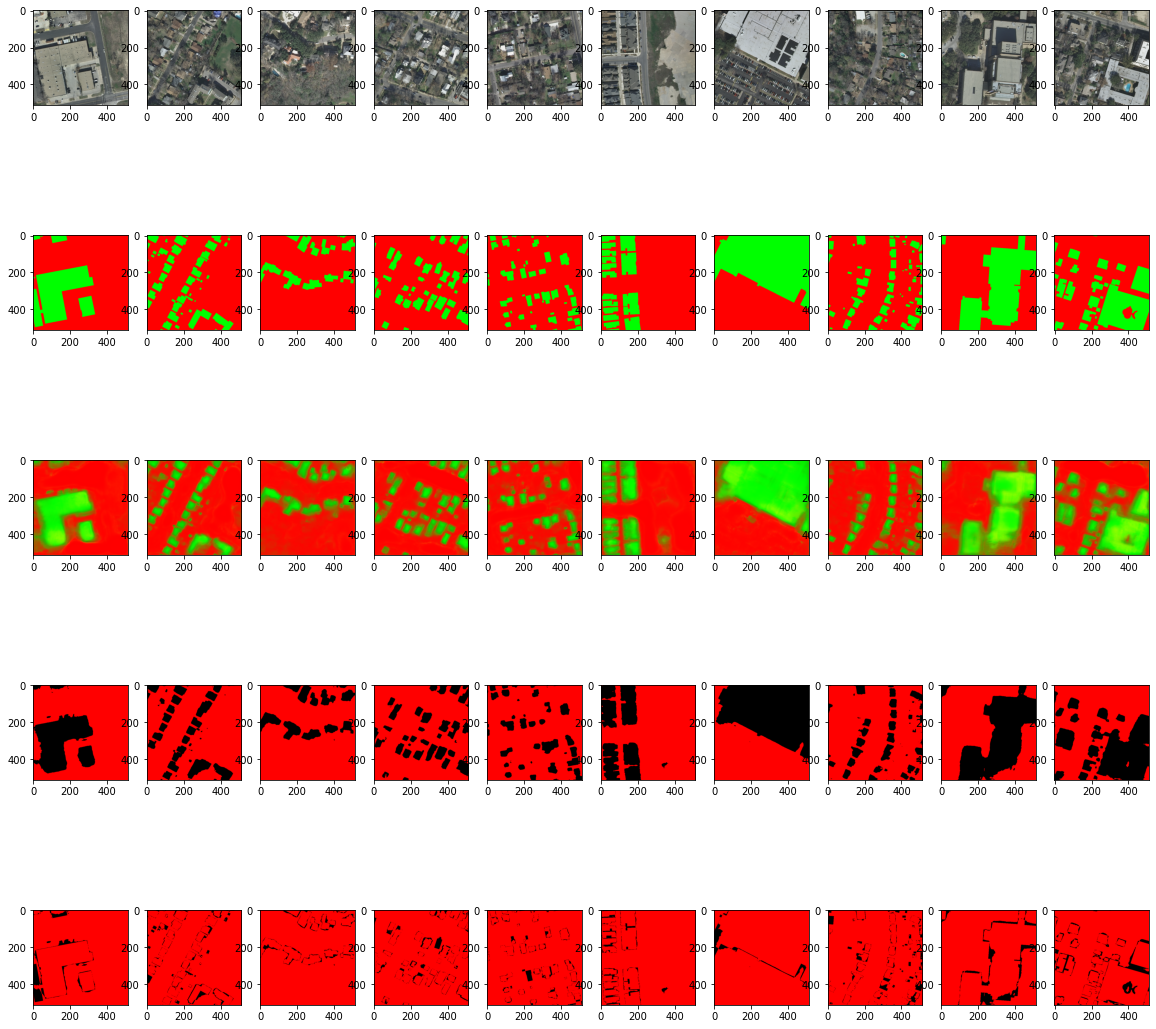

In [ ]:
###############################
# PREDICCIONES
###############################

# Se selecciona un lote, el 1 por ejemplo
[X_predict,y_predict]=testGenerator.__getitem__(1)

# Se hace una predicción de sus ground truths
# con el modelo secuencial entrenado y evaluado
prediction = theModel.predict(X_predict)

# Se dibujan 5 filas de imágenes del lote 1

# La primera con las imágenes aéreas de referencia
# La segunda con los ground truth
# La tercera con las predicciones efectuadas con probabilidades
# La cuarta con las predicciones aproximadas a sus clases con argmax
# La quinta con las diferencias entre las predicciones aproximadas a sus clases y los ground truth (en valor absoluto)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,len(X_predict),figsize=(20, 20))

for i in range(len(y_predict)):
    ax1[i].imshow(X_predict[i])
    # Se añade el canal B para poder ver el GT
    z = addBChannel(y_predict[i])
    ax2[i].imshow(z)
    # Se añade el canal B para poder ver la predicción del GT
    t = addBChannel(prediction[i])
    ax3[i].imshow(t)
    # Los ground truth predichos se aproximan a su clase
    # con la función argmax
    y = convertIntoImg(reverseGt(prediction[i].argmax(axis=-1)))
    ax4[i].imshow(y)
    # Se resta el gt con la predicción redondeada a su clase y se coge el valor absoluto de la diferencia de cada pixel
    # Así en la imagen refleja cúanto le falta a la predicción aproximada para ser el gt exacto
    d = convertIntoImg(getDiffBetweenGt(prediction[i].argmax(axis=-1), getRchannel(y_predict[i])))
    ax5[i].imshow(d)

Se observa que las predicciones son mejores que en el modelo secuencial, por ejemplo en el edificio grande de la imagen nº 7

Y finalmente las medidas...

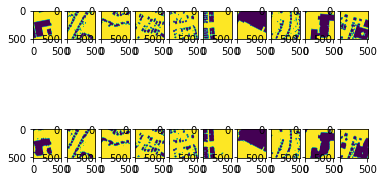

Accuracy: 0.950 Precision: 0.970 Recall: 0.962 F1 score: 0.966


In [ ]:
# Cálculo de las medidas

# Carga las predicciones y sus gts
allPredictions,allGT=load_data(10)

# Los pinta
plot_all(allPredictions,allGT)

# Obtiene el nº total de falsos y verdaderos positivos y negativos
tp,fp,tn,fn=get_global_cmatrix(allPredictions,allGT)

# Calcula las métricas
a,p,r,f1=get_stats(tp,fp,tn,fn)

# Displaya las métricas
print('Accuracy: %.3f Precision: %.3f Recall: %.3f F1 score: %.3f'%(a,p,r,f1))

También se observa que las medidas son mejores que en el secuencial